# Filter fragments for synthesizability

## Aim of this notebook

This notebook is filtering the fragments for synthesizabity.
The first filter checks the availablility of similar buyable building blocks in Enamine REAL Space, to ensure that the resulting molecules can easily be generated (https://enamine.net/compound-collections/real-compounds/real-space-navigator) .
The second filter calculates the SYnthetic Bayesian Accessibility (SYBA), which calculates an estimate wether a fragment is more likely easy to synthesize or hard to synthesize (https://jcheminf.biomedcentral.com/articles/10.1186/s13321-020-00439-2).

## Table of contents
* 1. Load fragment library
* 2. Apply pre-filters
* 3. Filter for buyable building blocks
   * 3.1. Data preparation
   * 3.2. Filter fragments for buyable building blocks
* 4. Filter for SYnthetic Bayesian Accessibility (SYBA)
* 5. Analyse accepted/rejected fragments

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import math
from pathlib import Path

import pandas as pd
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem, Draw, Lipinski, PandasTools

from utils import *

from kinfraglib import utils
from kinfraglib import filters

In [4]:
# Needed to display ROMol images in DataFrames
PandasTools.RenderImagesInAllDataFrames(images=True)

## Globals

In [5]:
# Path to data
HERE = Path(_dh[-1])
PATH_DATA = HERE / '../data'

2:1: E265 block comment should start with '# '
3:1: E265 block comment should start with '# '


## 1. Load fragment library

In [6]:
fragment_library = utils.read_fragment_library(PATH_DATA / 'fragment_library')

In [7]:
fragment_library.keys()

dict_keys(['AP', 'FP', 'SE', 'GA', 'B1', 'B2', 'X'])

In [8]:
pd.concat(fragment_library).reset_index(drop=True).shape

(8347, 15)

## 2. Apply pre-filters
Pre-filters are 
- removing fragments in pool X
- removing duplicates
- removing fragments without dummy atoms (unfragmented ligands)
- removing fragments only connecting to pool X

In [9]:
fragment_library_pre_filtered = filters.prefilters.pre_filters(
    fragment_library)

,subpocket,smiles,ROMol,ROMol_dummy,ROMol_original,kinase,family,group,complex_pdb,ligand_pdb,alt,chain,atom_subpockets,atom_environments,smiles_dummy,fragment_count,connections,connections_name
0,AP,Nc1c[nH]c2ncccc12,,,,AAK1,NAK,Other,5l4q,LKB,A,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP F...,16 16 16 16 16 16 16 16 16 16 16 16 16 5 5 na na,[11*]c1cnc2[nH]cc(N[27*])c2c1,3,"[FP, SE]","[AP=FP, AP=SE]"
1,AP,N/C(=C1\C(=O)Nc2ccccc21)c1ccccc1,,,,AAK1,NAK,Other,5te0,XIN,,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 ...,[12*]N/C(=C1\C(=O)Nc2cc([20*])ccc21)c1ccccc1,3,"[SE, GA]","[AP=SE, AP=GA]"
2,AP,Cc1cc(N)[nH]n1,,,,ABL1,Abl,TK,2f4j,VX6,,A,AP AP AP AP AP AP AP AP AP AP AP AP AP SE,5 5 14 14 14 14 14 14 14 8 8 8 8 na,[22*]Nc1cc(C)n[nH]1,9,[SE],[AP=SE]
3,AP,Nc1ncc(C=O)s1,,,,ABL1,Abl,TK,2gqg,1N1,B,A,AP AP AP AP AP AP AP AP AP AP GA SE,14 14 14 6 5 5 14 14 14 6 na na,[15*]Nc1ncc(C([41*])=O)s1,17,"[GA, SE]","[AP=GA, AP=SE]"
4,AP,COCC(=O)n1cc2[nH]nc(NC=O)c2c1,,,,ABL1,Abl,TK,2v7a,627,,B,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,8 8 8 8 8 5 5 6 6 8 8 8 8 8 8 8 8 8 8 3 3 3 3 ...,[8*]C(=O)Nc1n[nH]c2cn(C(=O)[C@@H]([46*])OC)cc12,3,"[SE, FP]","[AP=SE, AP=FP]"

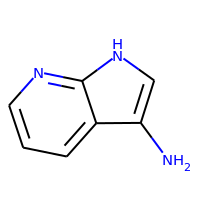
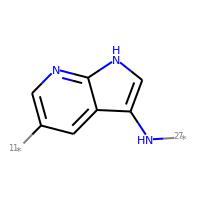
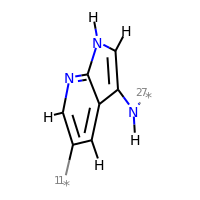
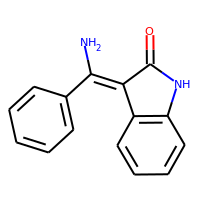
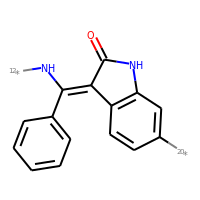
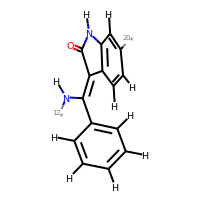
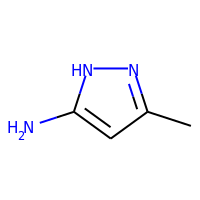
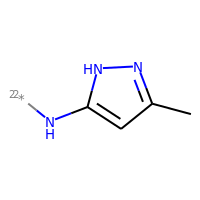
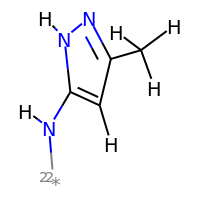
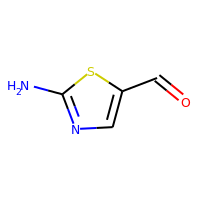
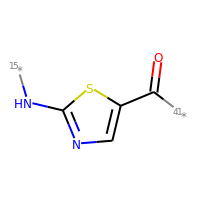
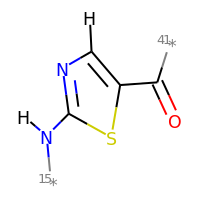
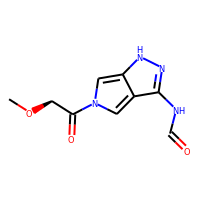
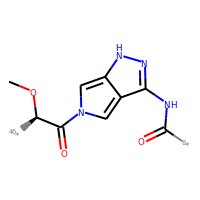
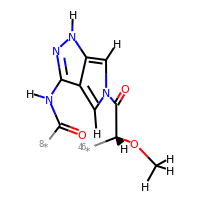

In [10]:
fragment_library_pre_filtered['AP'].head()

In [11]:
pd.concat([filters.analysis.count_fragments(fragment_library,
                                            'original'),
           filters.analysis.count_fragments(fragment_library_pre_filtered,
                                            'pre_filtered')],
          axis=1)

,original,pre_filtered
subpocket,,
AP,2832,1082
FP,2093,965
SE,1730,663
GA,1146,331
B1,115,47
B2,106,51


For further use we save fragment_library as fragment_library_original and fragment_library_pre_filtered as fragment_library.

In [12]:
fragment_library_original = fragment_library.copy()
fragment_library = fragment_library_pre_filtered.copy()

## 3. Filter for buyable building blocks
- 3.1. Data preparation
- 3.2. Filter fragments for buyable building blocks

### 3.1. Data preparation
- save fragments without dummy atoms for DataWarrior (https://openmolecules.org/datawarrior/download.html)
- load fragments in DataWarrior & request for Enamine REAL space building blocks

In [13]:
# save smiles without dummy atoms in sdf files for DataWarrior
filters.utils.save_smiles_wo_dummy(fragment_library, PATH_DATA)

- Open DataWarrior
- Open sile smiles_wo_dummy.sdf -> choose 'yes' when DataWarrior asks if it should interpret stereo centers as absolute
- Go to Database -> Search Enamine Building Blocks -> choose superstructures at the top dropdown menu -> set maximum row count to 100000 -> set minimun package size to 1 -> choose " retrieve cheapest..." at the bottom -> run query
- file -> save special -> SDfile -> Enamine_Building_Blocks.sdf and save it in a folder called DataWarrior in same directory as your fragment library

Note: if you only want to use exact matches choose "exact structures" in the dropdoen menu

### 3.2. Filter fragments for buyable building blocks

In [14]:
d = filters.building_blocks.check_building_blocks(
    fragment_library,
    str(str(PATH_DATA)+'/DataWarrior/Enamine_Building_Blocks.sdf'))

In [15]:
bb_frags = d['enamine_bb_fragments']
not_bb_frags = d['not_enamine_bb_fragments']
fragment_library_enamine = d['fragment_library']

,subpocket,smiles,ROMol,ROMol_dummy,ROMol_original,kinase,family,group,complex_pdb,ligand_pdb,alt,chain,atom_subpockets,atom_environments,smiles_dummy,fragment_count,connections,connections_name,bool_bb
0,AP,Nc1c[nH]c2ncccc12,,,,AAK1,NAK,Other,5l4q,LKB,A,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP F...,16 16 16 16 16 16 16 16 16 16 16 16 16 5 5 na na,[11*]c1cnc2[nH]cc(N[27*])c2c1,3,"[FP, SE]","[AP=FP, AP=SE]",0
1,AP,N/C(=C1\C(=O)Nc2ccccc21)c1ccccc1,,,,AAK1,NAK,Other,5te0,XIN,,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 ...,[12*]N/C(=C1\C(=O)Nc2cc([20*])ccc21)c1ccccc1,3,"[SE, GA]","[AP=SE, AP=GA]",0
2,AP,Cc1cc(N)[nH]n1,,,,ABL1,Abl,TK,2f4j,VX6,,A,AP AP AP AP AP AP AP AP AP AP AP AP AP SE,5 5 14 14 14 14 14 14 14 8 8 8 8 na,[22*]Nc1cc(C)n[nH]1,9,[SE],[AP=SE],1
3,AP,Nc1ncc(C=O)s1,,,,ABL1,Abl,TK,2gqg,1N1,B,A,AP AP AP AP AP AP AP AP AP AP GA SE,14 14 14 6 5 5 14 14 14 6 na na,[15*]Nc1ncc(C([41*])=O)s1,17,"[GA, SE]","[AP=GA, AP=SE]",1
4,AP,COCC(=O)n1cc2[nH]nc(NC=O)c2c1,,,,ABL1,Abl,TK,2v7a,627,,B,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,8 8 8 8 8 5 5 6 6 8 8 8 8 8 8 8 8 8 8 3 3 3 3 ...,[8*]C(=O)Nc1n[nH]c2cn(C(=O)[C@@H]([46*])OC)cc12,3,"[SE, FP]","[AP=SE, AP=FP]",0

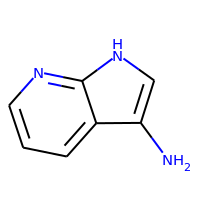
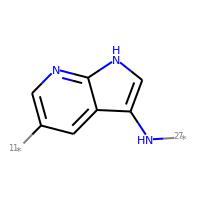
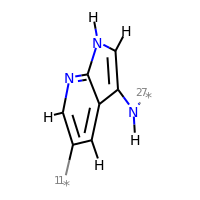
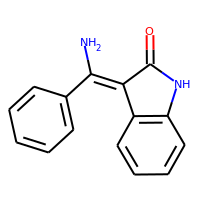
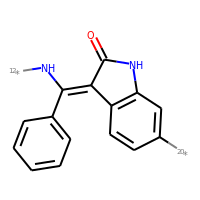
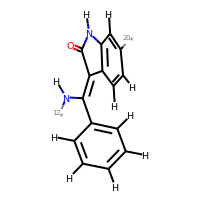
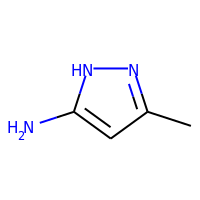
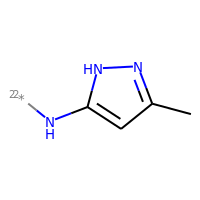
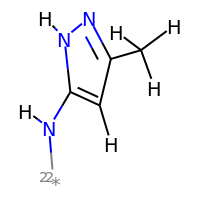
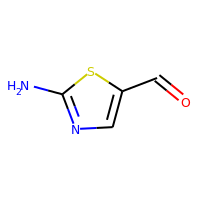
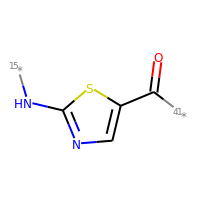
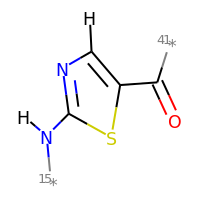
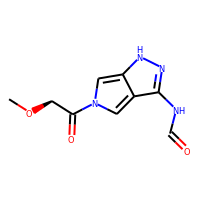
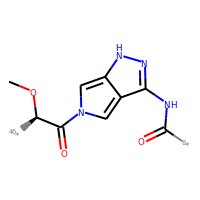
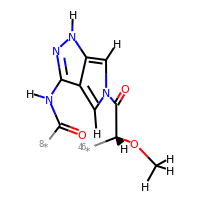

In [16]:
fragment_library_enamine['AP'].head()

In [17]:
pd.concat([filters.analysis.count_fragments(
    fragment_library_enamine,
    "pre_filtered"),
          filters.analysis.count_accepted_rejected(
              fragment_library_enamine,
              'bool_bb',
              'enamine')],
          axis=1)

,pre_filtered,accepted_enamine,rejected_enamine
subpocket,,,
AP,1082,183,899
FP,965,241,724
SE,663,172,491
GA,331,156,175
B1,47,21,26
B2,51,21,30


In [18]:
# save superstructure df as fragment_library_synthesizability to use
fragment_library_synthesizability = fragment_library_enamine.copy()

## 4. Filter for SYnthetic Bayesian Accessibility (SYBA)

https://github.com/lich-uct/syba

In [19]:
d_sybas = filters.syba.calc_syba(
    fragment_library_synthesizability,
    cutoff=0)

In [20]:
accepted_frags_syba = d_sybas['df_accepted']
rejected_frags_syba = d_sybas['df_rejected']
fragment_library_synthesizability = d_sybas['fragment_library']
sybascore = d_sybas['sybas']

,subpocket,smiles,ROMol,ROMol_dummy,ROMol_original,kinase,family,group,complex_pdb,ligand_pdb,alt,chain,atom_subpockets,atom_environments,smiles_dummy,fragment_count,connections,connections_name,bool_bb
0,AP,O=C1NCCCc2cc[nH]c21,,,,ACK,Ack,TK,1u4d,DBQ,,B,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 na,[19*]=C1CCNC(=O)c2[nH]ccc21,4,[FP],[AP=FP],0
1,AP,Cc1ccc2c(c1)NC(=O)Nc1cnc(N)nc1-2,,,,ACK,Ack,TK,6vqm,R7P,,B,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,16 16 16 16 16 16 8 8 8 8 16 16 16 5 5 16 16 1...,[12*]Nc1ncc2c(n1)-c1ccc(C)cc1NC(=O)N2,1,[SE],[AP=SE],0
2,AP,C[C@@H]1SCc2ncncc21,,,,AKT1,Akt,AGC,3ow4,SMY,,B,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 1...,[17*]c1ncnc2c1[C@H](C)SC2,1,[FP],[AP=FP],0
3,AP,C[C@@H]1C[C@@H](O)c2ncncc21,,,,AKT1,Akt,AGC,4ekl,0RF,,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 1...,[14*]c1ncnc2c1[C@H](C)C[C@H]2O,1,[FP],[AP=FP],0
4,AP,C[C@@H]1CC(=O)Nc2ncncc21,,,,AKT1,Akt,AGC,6ccy,EX4,A,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 1...,[36*]c1ncnc2c1[C@H](C)CC(=O)N2,1,[FP],[AP=FP],0

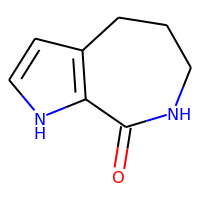
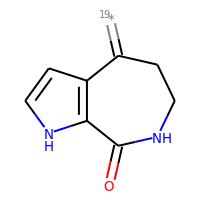
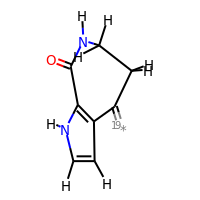
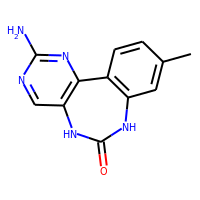
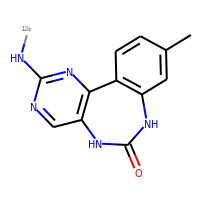
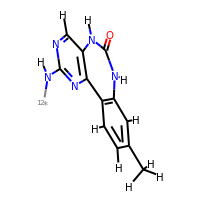
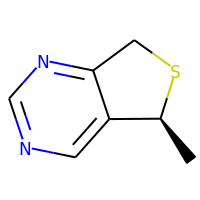
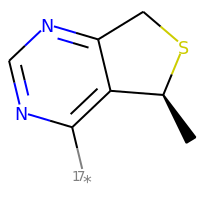
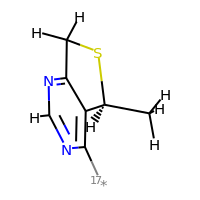
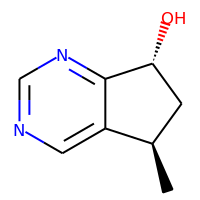
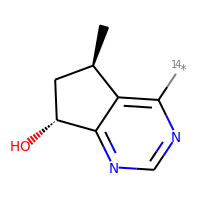
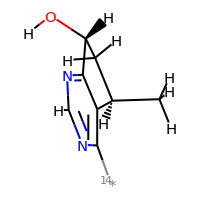
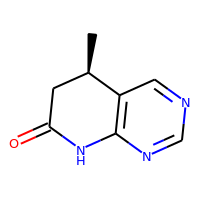
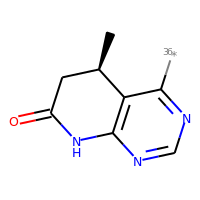
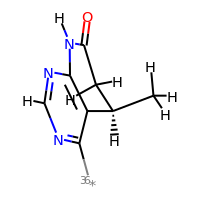

In [21]:
accepted_frags_syba['AP'].head()

,subpocket,smiles,ROMol,ROMol_dummy,ROMol_original,kinase,family,group,complex_pdb,ligand_pdb,alt,chain,atom_subpockets,atom_environments,smiles_dummy,fragment_count,connections,connections_name,bool_bb
0,AP,Nc1c[nH]c2ncccc12,,,,AAK1,NAK,Other,5l4q,LKB,A,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP F...,16 16 16 16 16 16 16 16 16 16 16 16 16 5 5 na na,[11*]c1cnc2[nH]cc(N[27*])c2c1,3,"[FP, SE]","[AP=FP, AP=SE]",0
1,AP,N/C(=C1\C(=O)Nc2ccccc21)c1ccccc1,,,,AAK1,NAK,Other,5te0,XIN,,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 ...,[12*]N/C(=C1\C(=O)Nc2cc([20*])ccc21)c1ccccc1,3,"[SE, GA]","[AP=SE, AP=GA]",0
2,AP,Cc1cc(N)[nH]n1,,,,ABL1,Abl,TK,2f4j,VX6,,A,AP AP AP AP AP AP AP AP AP AP AP AP AP SE,5 5 14 14 14 14 14 14 14 8 8 8 8 na,[22*]Nc1cc(C)n[nH]1,9,[SE],[AP=SE],1
3,AP,Nc1ncc(C=O)s1,,,,ABL1,Abl,TK,2gqg,1N1,B,A,AP AP AP AP AP AP AP AP AP AP GA SE,14 14 14 6 5 5 14 14 14 6 na na,[15*]Nc1ncc(C([41*])=O)s1,17,"[GA, SE]","[AP=GA, AP=SE]",1
4,AP,COCC(=O)n1cc2[nH]nc(NC=O)c2c1,,,,ABL1,Abl,TK,2v7a,627,,B,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,8 8 8 8 8 5 5 6 6 8 8 8 8 8 8 8 8 8 8 3 3 3 3 ...,[8*]C(=O)Nc1n[nH]c2cn(C(=O)[C@@H]([46*])OC)cc12,3,"[SE, FP]","[AP=SE, AP=FP]",0

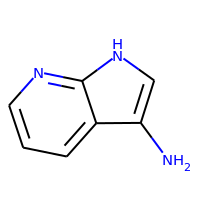
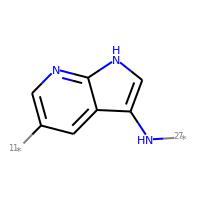
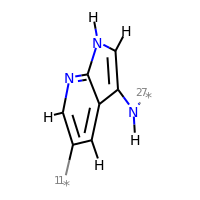
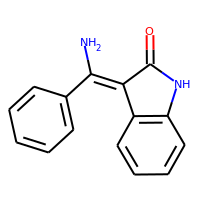
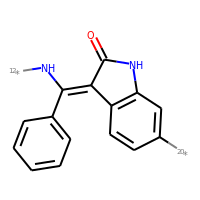
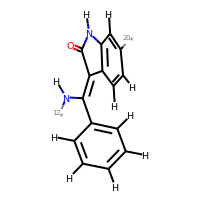
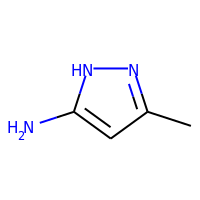
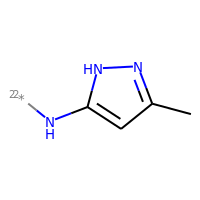
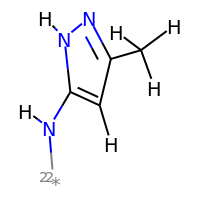
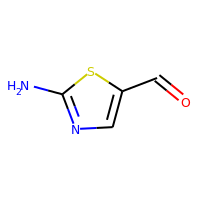
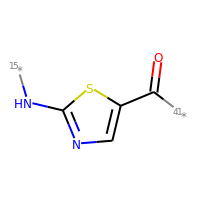
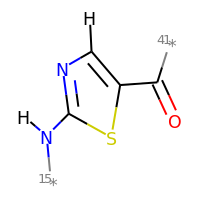
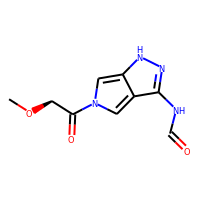
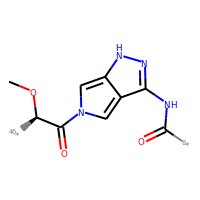
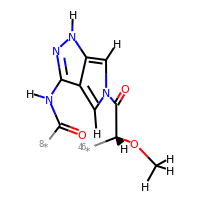

In [22]:
rejected_frags_syba['AP'].head()

,subpocket,smiles,ROMol,ROMol_dummy,ROMol_original,kinase,family,group,complex_pdb,ligand_pdb,alt,chain,atom_subpockets,atom_environments,smiles_dummy,fragment_count,connections,connections_name,bool_bb,bool_syba
0,AP,Nc1c[nH]c2ncccc12,,,,AAK1,NAK,Other,5l4q,LKB,A,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP F...,16 16 16 16 16 16 16 16 16 16 16 16 16 5 5 na na,[11*]c1cnc2[nH]cc(N[27*])c2c1,3,"[FP, SE]","[AP=FP, AP=SE]",0,0
1,AP,N/C(=C1\C(=O)Nc2ccccc21)c1ccccc1,,,,AAK1,NAK,Other,5te0,XIN,,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 ...,[12*]N/C(=C1\C(=O)Nc2cc([20*])ccc21)c1ccccc1,3,"[SE, GA]","[AP=SE, AP=GA]",0,0
2,AP,Cc1cc(N)[nH]n1,,,,ABL1,Abl,TK,2f4j,VX6,,A,AP AP AP AP AP AP AP AP AP AP AP AP AP SE,5 5 14 14 14 14 14 14 14 8 8 8 8 na,[22*]Nc1cc(C)n[nH]1,9,[SE],[AP=SE],1,0
3,AP,Nc1ncc(C=O)s1,,,,ABL1,Abl,TK,2gqg,1N1,B,A,AP AP AP AP AP AP AP AP AP AP GA SE,14 14 14 6 5 5 14 14 14 6 na na,[15*]Nc1ncc(C([41*])=O)s1,17,"[GA, SE]","[AP=GA, AP=SE]",1,0
4,AP,COCC(=O)n1cc2[nH]nc(NC=O)c2c1,,,,ABL1,Abl,TK,2v7a,627,,B,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,8 8 8 8 8 5 5 6 6 8 8 8 8 8 8 8 8 8 8 3 3 3 3 ...,[8*]C(=O)Nc1n[nH]c2cn(C(=O)[C@@H]([46*])OC)cc12,3,"[SE, FP]","[AP=SE, AP=FP]",0,0

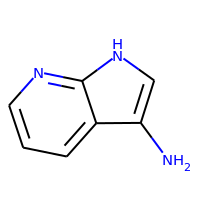
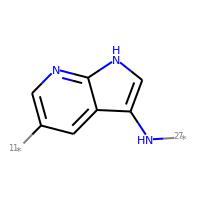
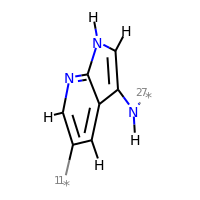
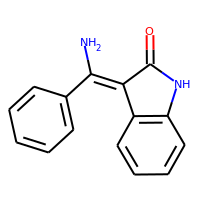
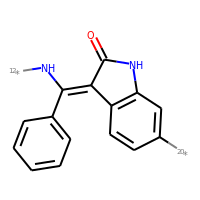
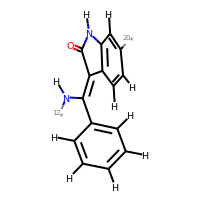
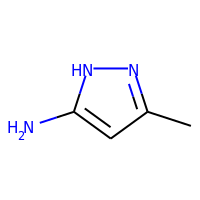
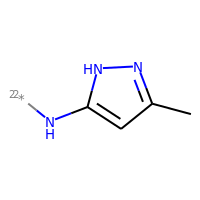
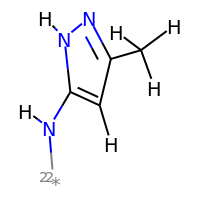
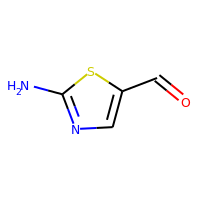
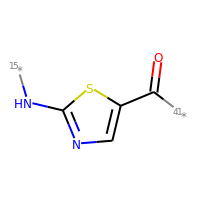
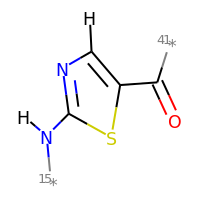
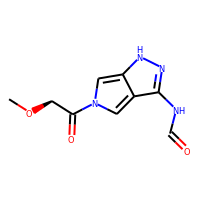
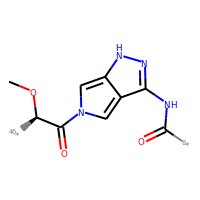
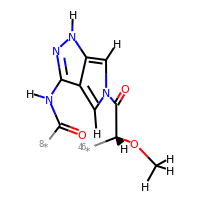

In [23]:
fragment_library_synthesizability['AP'].head()

In [24]:
pd.concat([filters.analysis.count_fragments(
    fragment_library_synthesizability,
    'pre_filtered'),
          filters.analysis.count_accepted_rejected(
              fragment_library_synthesizability,
              'bool_syba', 'syba')],
          axis=1)

,pre_filtered,accepted_syba,rejected_syba
subpocket,,,
AP,1082,112,970
FP,965,199,766
SE,663,64,599
GA,331,29,302
B1,47,10,37
B2,51,5,46


Todo: more analysis

## 5. Analyse accepted/rejected fragments

,subpocket,smiles,ROMol,ROMol_dummy,ROMol_original,kinase,family,group,complex_pdb,ligand_pdb,...,atom_subpockets,atom_environments,smiles_dummy,fragment_count,connections,connections_name,bool_bb,bool_syba,bool,bool_1
0,AP,Nc1c[nH]c2ncccc12,,,,AAK1,NAK,Other,5l4q,LKB,...,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP F...,16 16 16 16 16 16 16 16 16 16 16 16 16 5 5 na na,[11*]c1cnc2[nH]cc(N[27*])c2c1,3,"[FP, SE]","[AP=FP, AP=SE]",0,0,0,0
1,AP,N/C(=C1\C(=O)Nc2ccccc21)c1ccccc1,,,,AAK1,NAK,Other,5te0,XIN,...,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 ...,[12*]N/C(=C1\C(=O)Nc2cc([20*])ccc21)c1ccccc1,3,"[SE, GA]","[AP=SE, AP=GA]",0,0,0,0
2,AP,Cc1cc(N)[nH]n1,,,,ABL1,Abl,TK,2f4j,VX6,...,AP AP AP AP AP AP AP AP AP AP AP AP AP SE,5 5 14 14 14 14 14 14 14 8 8 8 8 na,[22*]Nc1cc(C)n[nH]1,9,[SE],[AP=SE],1,0,0,1
3,AP,Nc1ncc(C=O)s1,,,,ABL1,Abl,TK,2gqg,1N1,...,AP AP AP AP AP AP AP AP AP AP GA SE,14 14 14 6 5 5 14 14 14 6 na na,[15*]Nc1ncc(C([41*])=O)s1,17,"[GA, SE]","[AP=GA, AP=SE]",1,0,0,1
4,AP,COCC(=O)n1cc2[nH]nc(NC=O)c2c1,,,,ABL1,Abl,TK,2v7a,627,...,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,8 8 8 8 8 5 5 6 6 8 8 8 8 8 8 8 8 8 8 3 3 3 3 ...,[8*]C(=O)Nc1n[nH]c2cn(C(=O)[C@@H]([46*])OC)cc12,3,"[SE, FP]","[AP=SE, AP=FP]",0,0,0,0

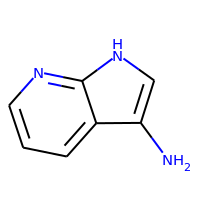
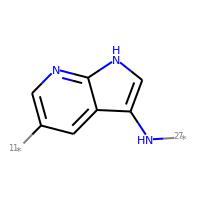
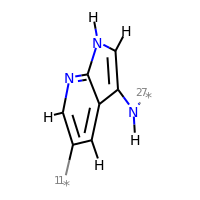
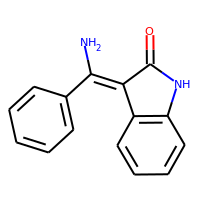
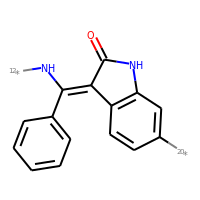
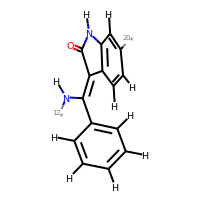
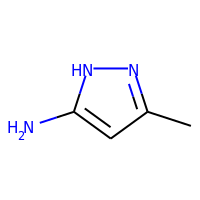
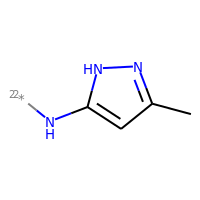
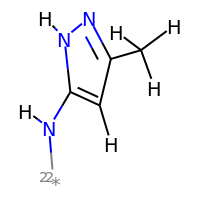
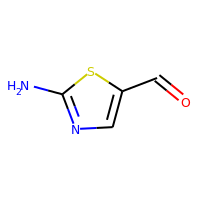
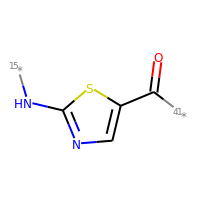
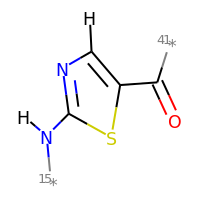
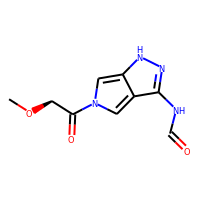
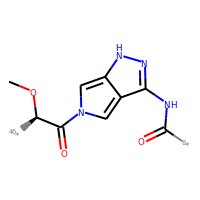
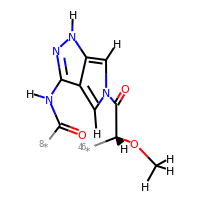

In [25]:
fragment_library_synthesizability = filters.analysis.number_of_accepted(
    fragment_library_synthesizability, columns=['bool_syba', 'bool_bb'],
    min_accepted=2)
fragment_library_synthesizability = filters.analysis.number_of_accepted(
    fragment_library_synthesizability,
    columns=['bool_syba', 'bool_bb'],
    min_accepted=1,
    name="bool_1")
fragment_library_synthesizability['AP'].head()

In [26]:
pd.concat([filters.analysis.count_fragments(
    fragment_library_synthesizability,
    'pre_filtered'),
          filters.analysis.count_accepted_rejected(
              fragment_library_synthesizability,
              'bool', 'both'),
          filters.analysis.count_accepted_rejected(
              fragment_library_synthesizability,
              'bool_syba', 'syba'),
          filters.analysis.count_accepted_rejected(
              fragment_library_synthesizability,
              'bool_bb', 'enamine_superstr'),
          filters.analysis.count_accepted_rejected(
              fragment_library_synthesizability,
              'bool_1', 'one')],
          axis=1)

,pre_filtered,accepted_both,rejected_both,accepted_syba,rejected_syba,accepted_enamine_superstr,rejected_enamine_superstr,accepted_one,rejected_one
subpocket,,,,,,,,,
AP,1082,3,1079,112,970,183,899,292,790
FP,965,40,925,199,766,241,724,400,565
SE,663,19,644,64,599,172,491,217,446
GA,331,11,320,29,302,156,175,174,157
B1,47,1,46,10,37,21,26,30,17
B2,51,2,49,5,46,21,30,24,27


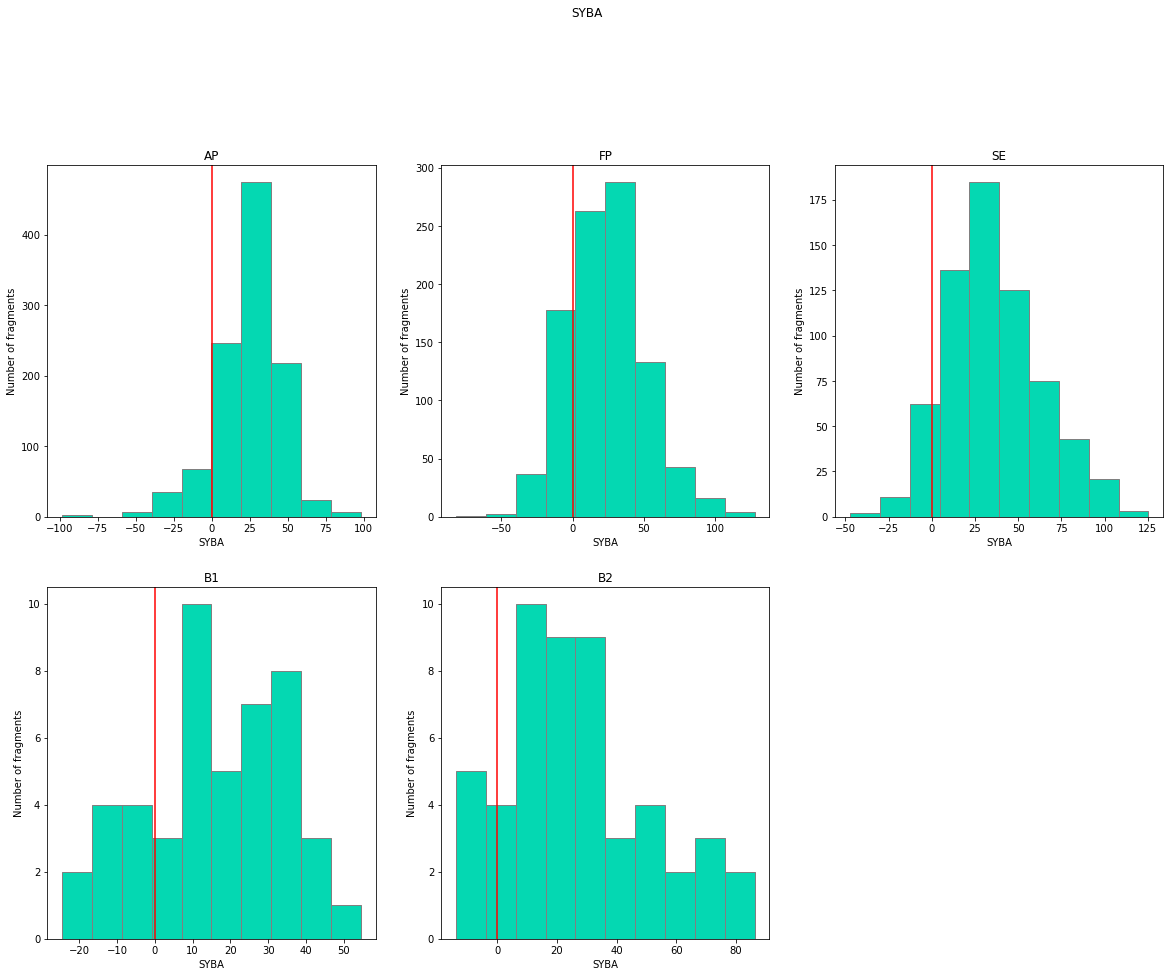

In [27]:
filters.plots.make_hists(
    sybascore,
    fragment_library,
    'SYBA',
    plot_stats=False,
    cutoff=0)